In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import os
import scandir
import cv2
from IPython.display import Image, display
from scipy.misc import imresize, imread
%matplotlib inline

## Scan subfolders and files to append to lists. 

In [2]:
folders = []
for entry in scandir.scandir('C:/Users/vinit/Desktop/SCU/Spring 2018/FNCE 3490/Final project/Image src'):
    if entry.is_dir():
        folders.append(entry.path)
print ('No. of patients: ' + str(len(folders)))

No. of patients: 50


In [3]:
folder_extensions_0 = []
folder_extensions_1 = []

def add_extensions(folder_names): 
    for folder in folder_names:
        with_0 = folder + '/0'
        with_1 = folder + '/1'
        folder_extensions_0.append(with_0)
        folder_extensions_1.append(with_1)

add_extensions(folders)

In [4]:
files = []
from os import listdir
for folder in folder_extensions_0:
    for file in listdir(folder):
        if '.png' in file: 
            file_0 = folder + '/' + file
            files.append(file_0)
for folder in folder_extensions_1:
    for file in listdir(folder):
        if '.png' in file: 
            file_1 = folder + '/' + file
            files.append(file_1)

print ('No. of images: ' + str(len(files)))

No. of images: 50166


In [5]:
X = []
Y = []
for file in files:
    image = cv2.imread(file)
    imagere = cv2.resize(image,(50,50))
    X.append (imagere)
    if '_class0' in file:
        Y.append(0)
    else:
        Y.append(1)

In [6]:
X = np.array(X)
Y = np.array(Y)

In [7]:
print ('no. of images: ' + str(len(X)))
print ('no of images with the tumor ' + str(sum(Y)))
print ('no of images without the tumor ' + str(len(Y)-sum(Y)))
print ('dimension of each picture' + str(X[0].shape))

no. of images: 50166
no of images with the tumor 11669
no of images without the tumor 38497
dimension of each picture(50, 50, 3)


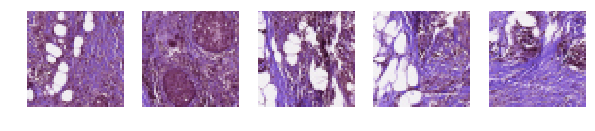

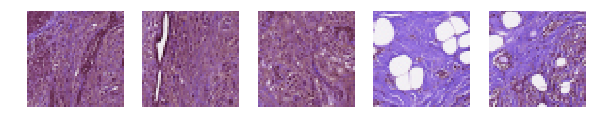

In [8]:
pos = X[Y == 1]
neg = X[Y == 0]

#no_of_columns=4
figsize=(10,10)


fig1 = plt.figure(figsize=figsize)
column1 = 0
for i in range(0,5):
    column1 += 1
    fig1.add_subplot(1, 5, column1)
    plt.imshow(neg[i])
    plt.axis('off')
fig2 = plt.figure(figsize=figsize)
column2 = 0
for i in range(0,5):
    column2 += 1
    fig2.add_subplot(1, 5, column2)
    plt.imshow(pos[i])
    plt.axis('off')

## Run multiple classifiers on the dataset

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [10]:
X_train = X_train[0:10000] 
Y_train = Y_train[0:10000]
X_test = X_test[0:3000] 
Y_test = Y_test[0:3000]

In [11]:
print (len(X_train))
print (len(X_test))
print (len(Y_train))
print (len(Y_test))

10000
3000
10000
3000


In [12]:
#Normalize data
X_train = X_train/255.0
X_test = X_test/255.0

In [13]:
X_train.shape

(10000, 50, 50, 3)

In [14]:
len(X_train)

10000

## CNN

In [15]:
print ('dimensions of training dataset '+ str(X_train.shape))
print ('dimensions of test dataset '+ str(X_test.shape))

dimensions of training dataset (10000, 50, 50, 3)
dimensions of test dataset (3000, 50, 50, 3)


In [16]:
import keras
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
import sklearn
from keras import backend as K
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [17]:
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

In [18]:
X_train[0].shape

(50, 50, 3)

## I CNN model 
 -  batch size = 100
 -  15 epochs
 -  activation layer = sigmoid
 -  kernel size = 3x3 
 -  loss function = mean_squared_error
 -  optimizer = sgd

In [33]:
batch_size = 100
num_classes = 2
epochs = 15 

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                 activation='sigmoid',
                 input_shape=X_train[0].shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [34]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('val_acc'))
        self.loss.append(logs.get('val_loss'))
        
history = AccuracyHistory()

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[history])

Train on 10000 samples, validate on 3000 samples
Epoch 1/15
10000/10000 [==============================] - 42s 4ms/step - loss: 0.1772 - acc: 0.7713 - val_loss: 0.1713 - val_acc: 0.7807
Epoch 2/15
10000/10000 [==============================] - 45s 4ms/step - loss: 0.1768 - acc: 0.7713 - val_loss: 0.1718 - val_acc: 0.7807
Epoch 3/15
10000/10000 [==============================] - 46s 5ms/step - loss: 0.1768 - acc: 0.7713 - val_loss: 0.1713 - val_acc: 0.7807
Epoch 4/15
10000/10000 [==============================] - 45s 5ms/step - loss: 0.1768 - acc: 0.7713 - val_loss: 0.1713 - val_acc: 0.7807
Epoch 5/15
10000/10000 [==============================] - 40s 4ms/step - loss: 0.1765 - acc: 0.7713 - val_loss: 0.1714 - val_acc: 0.7807
Epoch 6/15
10000/10000 [==============================] - 41s 4ms/step - loss: 0.1766 - acc: 0.7713 - val_loss: 0.1720 - val_acc: 0.7807
Epoch 7/15
10000/10000 [==============================] - 44s 4ms/step - loss: 0.1765 - acc: 0.7713 - val_loss: 0.1713 - val_acc:

In [35]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.17092460004488627
Test accuracy: 0.7806666666666666


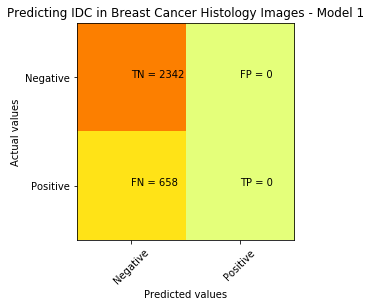

In [36]:
Y_pred = model.predict(X_test)
Y_pred_class = np.argmax(Y_pred,axis = 1) 
Y_actual = np.argmax(Y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_actual, Y_pred_class) 

plt.clf()
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Predicting IDC in Breast Cancer Histology Images - Model 1')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(confusion_mtx[i][j]))
plt.show()

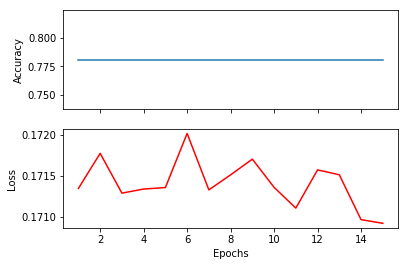

In [37]:
ax1 = plt.subplot(211)
plt.plot(range(1,16), history.acc)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('Accuracy')

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(range(1,16), history.loss, color='red')
plt.setp(ax2.get_xticklabels(), fontsize=10)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

## II CNN model 
 -  batch size = 128
 -  15 epochs
 -  activation layer = relu
 -  kernel size = 3x3 
 -  loss function = categorical_crossentropy
 -  optimizer = sgd

In [38]:
batch_size = 128
num_classes = 2
epochs = 15 

model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=X_train[0].shape))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(100, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [39]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('val_acc'))
        self.loss.append(logs.get('val_loss'))
        
history = AccuracyHistory()

model1.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[history])

Train on 10000 samples, validate on 3000 samples
Epoch 1/15
10000/10000 [==============================] - 45s 5ms/step - loss: 0.5058 - acc: 0.7713 - val_loss: 0.4861 - val_acc: 0.7807
Epoch 2/15
10000/10000 [==============================] - 46s 5ms/step - loss: 0.4682 - acc: 0.7725 - val_loss: 0.4374 - val_acc: 0.7833
Epoch 3/15
10000/10000 [==============================] - 45s 4ms/step - loss: 0.4473 - acc: 0.7933 - val_loss: 0.4967 - val_acc: 0.7833
Epoch 4/15
10000/10000 [==============================] - 42s 4ms/step - loss: 0.4276 - acc: 0.8098 - val_loss: 0.4459 - val_acc: 0.8213
Epoch 5/15
10000/10000 [==============================] - 43s 4ms/step - loss: 0.4123 - acc: 0.8196 - val_loss: 0.8562 - val_acc: 0.3817
Epoch 6/15
10000/10000 [==============================] - 43s 4ms/step - loss: 0.4187 - acc: 0.8146 - val_loss: 0.4023 - val_acc: 0.8190
Epoch 7/15
10000/10000 [==============================] - 43s 4ms/step - loss: 0.3954 - acc: 0.8307 - val_loss: 0.5148 - val_acc:

In [40]:
score = model1.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3308109374046326
Test accuracy: 0.8569999998410542


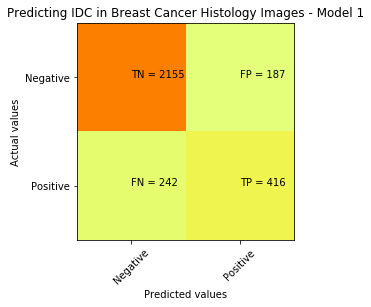

In [41]:
Y_pred = model1.predict(X_test)
Y_pred_class = np.argmax(Y_pred,axis = 1) 
Y_actual = np.argmax(Y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_actual, Y_pred_class) 

plt.clf()
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Predicting IDC in Breast Cancer Histology Images - Model 1')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(confusion_mtx[i][j]))
plt.show()

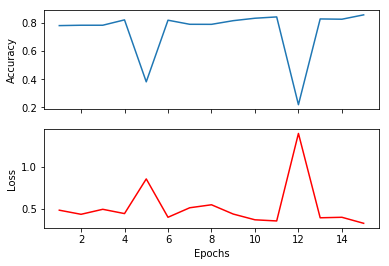

In [42]:
ax1 = plt.subplot(211)
plt.plot(range(1,16), history.acc)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('Accuracy')

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(range(1,16), history.loss, color='red')
plt.setp(ax2.get_xticklabels(), fontsize=10)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

## III CNN model 
 -  batch size = 128
 -  15 epochs
 -  activation layer = relu
 -  kernel size = 5x5 
 -  loss function = categorical_crossentropy
 -  optimizer = sgd
 -  3 layers + Full connection layer
 -  500 nodes under Dense layer
 -  Dropout layers

In [43]:
batch_size = 128
num_classes = 2
epochs = 15 

model2 = Sequential()

model2.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=X_train[0].shape))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))


model2.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=X_train[0].shape))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Conv2D(86, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=X_train[0].shape))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(500, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [44]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('val_acc'))
        self.loss.append(logs.get('val_loss'))
        
history = AccuracyHistory()

model2.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[history])

Train on 10000 samples, validate on 3000 samples
Epoch 1/15
10000/10000 [==============================] - 108s 11ms/step - loss: 0.4770 - acc: 0.8102 - val_loss: 0.3859 - val_acc: 0.8127
Epoch 2/15
10000/10000 [==============================] - 117s 12ms/step - loss: 0.4177 - acc: 0.8293 - val_loss: 0.3925 - val_acc: 0.8310
Epoch 3/15
10000/10000 [==============================] - 128s 13ms/step - loss: 0.3938 - acc: 0.8357 - val_loss: 0.5558 - val_acc: 0.7223
Epoch 4/15
10000/10000 [==============================] - 143s 14ms/step - loss: 0.3818 - acc: 0.8364 - val_loss: 0.5010 - val_acc: 0.8020
Epoch 5/15
10000/10000 [==============================] - 119s 12ms/step - loss: 0.3715 - acc: 0.8426 - val_loss: 0.3310 - val_acc: 0.8623
Epoch 6/15
10000/10000 [==============================] - 119s 12ms/step - loss: 0.3639 - acc: 0.8444 - val_loss: 0.3636 - val_acc: 0.8567
Epoch 7/15
10000/10000 [==============================] - 117s 12ms/step - loss: 0.3618 - acc: 0.8486 - val_loss: 0.3

In [45]:
score = model2.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.33108503627777097
Test accuracy: 0.862


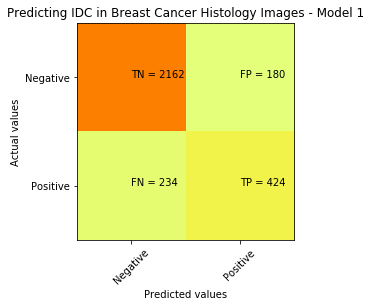

In [46]:
Y_pred = model2.predict(X_test)
Y_pred_class = np.argmax(Y_pred,axis = 1) 
Y_actual = np.argmax(Y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_actual, Y_pred_class) 

plt.clf()
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Predicting IDC in Breast Cancer Histology Images - Model 1')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(confusion_mtx[i][j]))
plt.show()

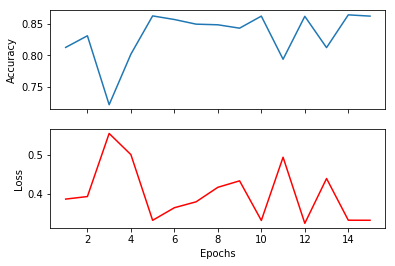

In [47]:
ax1 = plt.subplot(211)
plt.plot(range(1,16), history.acc)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('Accuracy')

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(range(1,16), history.loss, color='red')
plt.setp(ax2.get_xticklabels(), fontsize=10)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

## IV CNN model 
 -  batch size = 128
 -  15 epochs
 -  activation layer = relu
 -  kernel size = 5x5 
 -  loss function = categorical_crossentropy
 -  optimizer = RMSprop
 -  3 layers + Full connection layer
 -  500 nodes under Dense layer
 -  Dropout layers
 -  Batch normalization

In [19]:
batch_size = 128
num_classes = 2
epochs = 15 

model3 = Sequential()

model3.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=X_train[0].shape))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))


model3.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=X_train[0].shape))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Conv2D(86, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=X_train[0].shape))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(500, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(num_classes, activation='softmax'))

model3.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

In [20]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('val_acc'))
        self.loss.append(logs.get('val_loss'))
        
history = AccuracyHistory()

model3.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[history])

Train on 10000 samples, validate on 3000 samples
Epoch 1/15
10000/10000 [==============================] - 171s 17ms/step - loss: 0.5562 - acc: 0.8038 - val_loss: 0.7650 - val_acc: 0.8487
Epoch 2/15
10000/10000 [==============================] - 171s 17ms/step - loss: 0.4108 - acc: 0.8312 - val_loss: 0.4908 - val_acc: 0.8067
Epoch 3/15
10000/10000 [==============================] - 171s 17ms/step - loss: 0.3682 - acc: 0.8486 - val_loss: 2.0175 - val_acc: 0.7810
Epoch 4/15
10000/10000 [==============================] - 169s 17ms/step - loss: 0.3484 - acc: 0.8516 - val_loss: 0.3985 - val_acc: 0.8353
Epoch 5/15
10000/10000 [==============================] - 173s 17ms/step - loss: 0.3341 - acc: 0.8609 - val_loss: 3.0385 - val_acc: 0.7733
Epoch 6/15
10000/10000 [==============================] - 175s 17ms/step - loss: 0.3297 - acc: 0.8659 - val_loss: 1.7160 - val_acc: 0.7777
Epoch 7/15
10000/10000 [==============================] - 174s 17ms/step - loss: 0.3248 - acc: 0.8637 - val_loss: 1.1

In [21]:
score = model3.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0990830078125
Test accuracy: 0.7779999998410543


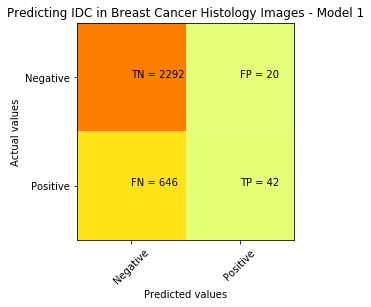

In [22]:
Y_pred = model3.predict(X_test)
Y_pred_class = np.argmax(Y_pred,axis = 1) 
Y_actual = np.argmax(Y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_actual, Y_pred_class) 

plt.clf()
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Predicting IDC in Breast Cancer Histology Images - Model 1')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(confusion_mtx[i][j]))
plt.show()

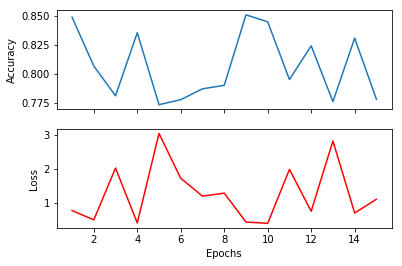

In [23]:
ax1 = plt.subplot(211)
plt.plot(range(1,16), history.acc)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('Accuracy')

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(range(1,16), history.loss, color='red')
plt.setp(ax2.get_xticklabels(), fontsize=10)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

## V Deep CNN model 
 -  batch size = 128
 -  10 epochs
 -  activation layer = relu
 -  kernel size = 3x3 
 -  loss function = categorical_crossentropy
 -  optimizer = RMSprop
 -  2 layers + Full connection layer
 -  500 nodes under Dense layer
 -  Add dropout layers
 -  Padding
 -  Data Augmentation

In [19]:
batch_size = 128
num_classes = 2
epochs = 10

model4 = Sequential()

model4.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                 padding='same',
                 activation='relu',
                 input_shape=X_train[0].shape))
model4.add(Conv2D(32, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

model4.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1),
                 padding='same',
                 activation='relu',
                 input_shape=X_train[0].shape))
model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

model4.add(Flatten())
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(num_classes, activation='softmax'))

RMS = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model4.compile(loss='categorical_crossentropy',
              optimizer=RMS,
              metrics=['accuracy'])

In [20]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
featurewise_center=False,  # set input mean to 0 over the dataset
samplewise_center=False,  # set each sample mean to 0
featurewise_std_normalization=False,  # divide inputs by std of the dataset
samplewise_std_normalization=False,  # divide each input by its std
zca_whitening=False,  # apply ZCA whitening
rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
horizontal_flip=True,  # randomly flip images
vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

# Fit the model on the batches generated by datagen.flow().
model4.fit_generator(datagen.flow(X_train, Y_train,
                                     batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    workers=4)

Using real-time data augmentation.
Epoch 1/10
79/79 [==============================] - 149s 2s/step - loss: 0.5419 - acc: 0.7711 - val_loss: 0.6361 - val_acc: 0.6170
Epoch 2/10
79/79 [==============================] - 150s 2s/step - loss: 0.4638 - acc: 0.7982 - val_loss: 0.4488 - val_acc: 0.8473
Epoch 3/10
79/79 [==============================] - 179s 2s/step - loss: 0.4186 - acc: 0.8330 - val_loss: 0.3926 - val_acc: 0.8437
Epoch 4/10
79/79 [==============================] - 188s 2s/step - loss: 0.4077 - acc: 0.8320 - val_loss: 0.3432 - val_acc: 0.8550
Epoch 5/10
79/79 [==============================] - 195s 2s/step - loss: 0.3969 - acc: 0.8398 - val_loss: 0.3468 - val_acc: 0.8553
Epoch 6/10
79/79 [==============================] - 177s 2s/step - loss: 0.3848 - acc: 0.8457 - val_loss: 0.3432 - val_acc: 0.8610
Epoch 7/10
79/79 [==============================] - 185s 2s/step - loss: 0.3796 - acc: 0.8474 - val_loss: 0.3896 - val_acc: 0.8470
Epoch 8/10
79/79 [==============================

In [21]:
scores = model4.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

3000/3000 [==============================] - 15s 5ms/step
Test loss: 0.33709187666575113
Test accuracy: 0.862333333492279


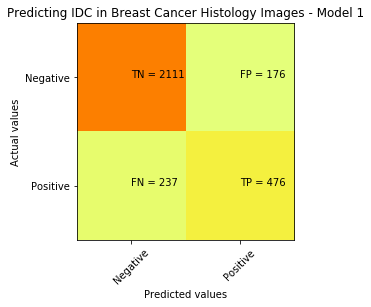

In [23]:
Y_pred = model4.predict(X_test)
Y_pred_class = np.argmax(Y_pred,axis = 1) 
Y_actual = np.argmax(Y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_actual, Y_pred_class) 

plt.clf()
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Predicting IDC in Breast Cancer Histology Images - Model 1')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(confusion_mtx[i][j]))
plt.show()